# Task 2
### Shop A would like to target new customers but they are unsure whom they should be targeting. Suggest prospective customers that have not purchased from shop A. who would be interested in their products offered.

# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('seaborn')

In [2]:
data = pd.read_excel('../data/rakuten_user_data.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
user_id                  1048575 non-null int64
gender                   1048575 non-null int64
user_age                 1045462 non-null float64
area_code                1046295 non-null float64
marital_flg              1048575 non-null int64
children_flg             1048575 non-null int64
lifetime_purchase_amt    983334 non-null float64
lifetime_purchase_cnt    983334 non-null float64
login_cnt_1m             1047793 non-null float64
login_cnt_3m             1047793 non-null float64
login_cnt_6m             1047793 non-null float64
shop_a_flg               1048575 non-null int64
shop_b_flg               1048575 non-null int64
shop_c_flg               1048575 non-null int64
dtypes: float64(7), int64(7)
memory usage: 112.0 MB


In [4]:
data.head()

,user_id,gender,user_age,area_code,marital_flg,children_flg,lifetime_purchase_amt,lifetime_purchase_cnt,login_cnt_1m,login_cnt_3m,login_cnt_6m,shop_a_flg,shop_b_flg,shop_c_flg
0,0,2,57.0,22.0,1,1,3800.0,297.0,32.0,90.0,188.0,1,0,0
1,1,2,54.0,13.0,0,0,92836.0,2409.0,38.0,103.0,246.0,0,1,0
2,2,2,42.0,20.0,2,2,90282.0,1786.0,59.0,160.0,284.0,1,0,0
3,3,1,55.0,26.0,1,1,151439.0,2984.0,35.0,146.0,342.0,0,1,0
4,4,2,55.0,13.0,1,1,101005.0,2728.0,103.0,418.0,824.0,0,1,0


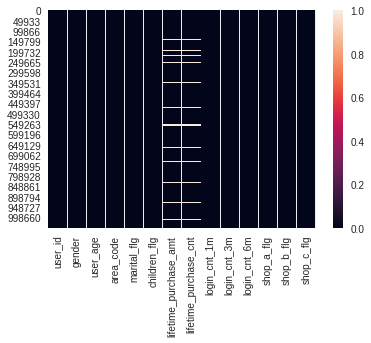

In [5]:
sns.heatmap(data.isnull())

In [6]:
data.fillna(data.mean(), inplace = True)

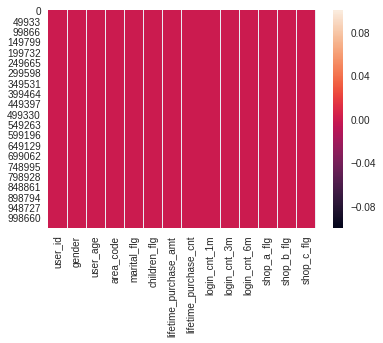

In [7]:
sns.heatmap(data.isnull())

# Modelling

Lets take a look at the correlation matrix of the data

In [8]:
targets = ['shop_a_flg', 'shop_b_flg', 'shop_c_flg']

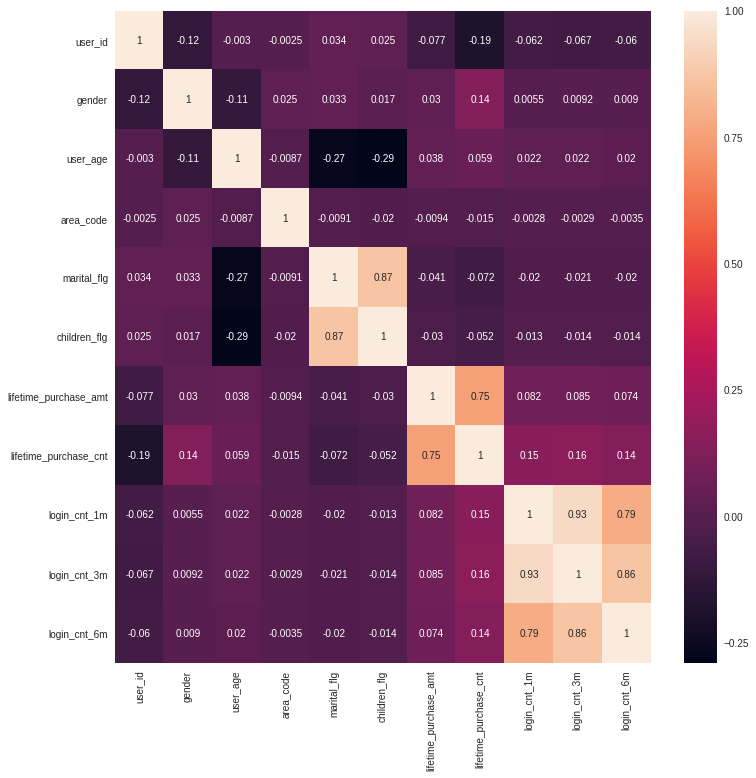

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(data.drop(targets, axis = 1).corr(), ax=ax, annot=True)

From the correlation matrix, we observe that there exist highly correlated features which are lifetime purchase amounts and login counts through different periods, in addition with marital status and children ownership. Hence we proceed to apply PCA to have a more compact representation of our features

On top of that, since user_id is completely random and has no significance towards which shop that a user will most likely to be shopping in. We remove them from our observation

#### Removing redundant feature - user_id

In [10]:
X = data.drop(targets, axis = 1)
X = X.drop('user_id', axis = 1)

#### Applying PCA preceded with Standard Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

pca = PCA(6)
X_compressed = pca.fit_transform(X_scaled)

## Algorithm Description

My clustering approach is inspired by a paper on prospective targeting by Patrik Norlin and Viktor Paulsrud (*https://pdfs.semanticscholar.org/9813/21d9f06a51110d6585bce4dcc14f624acbc0.pdf*).

In their paper, they described an algorithm called Clustering Based Classifier (CBC). 

The algorithm assumes that the the existing customers of a particular stakeholder can be divided into multiple segments. For our case, one segment of Shop A's customers might be casual shoppers and another segment might be the active shoppers. Another example of a differentiating feature might be the age of the customers. By applying K-Means Clustering, we are able to capture these abstract profiles of different customers and then lump them together as different unique segments of customers. 

Intuitively, if an arbitrarily chosen customer profile which might or might not be interested in Shop A falls close enough to the cluster centroids formed by the K-Means algorithm. We identify them as a prospective customer

This is a detailed description of the adapted algorithm:

1. Split the dataset into the training set which composes solely of Shop A's customers and the test set which comprises of potential customers.

2. Apply K-Means Clustering on the training set

3. Calculate a threshold distance *dt* to each centroid by taking the distance to the 90th percentile data point

4. Predict the closest cluster for the test set

5. Calculate the euclidean distance to the nearest centroid *dk*

6. For every observation:

    If *dk* < *dt*:

    We identify them as a *prospective customer*

    If *dk* > *dt*:

    We identify them as a *non-prospective customer*

### Step 1: Dataset Split

In [12]:
shop_a_observations = X_compressed[data['shop_a_flg'] == 1]

potential_customers_data = data[data['shop_a_flg'] == 0]
potential_customers_compressed = X_compressed[data['shop_a_flg'] == 0]

### Step 2: K-Means Clustering
#### Step 2.1 Elbow Method

In [13]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1,10)

distortions = []
for k in K:
    print("Doing K-Means Clustering with k = {}".format(k))
    kmeans = KMeans(k)
    kmeans.fit(shop_a_observations)
    distortions.append(sum(np.min(cdist(shop_a_observations, kmeans.cluster_centers_, 'euclidean'), axis=1)) / len(shop_a_observations))


Doing K-Means Clustering with k = 1
Doing K-Means Clustering with k = 2
Doing K-Means Clustering with k = 3
Doing K-Means Clustering with k = 4
Doing K-Means Clustering with k = 5
Doing K-Means Clustering with k = 6
Doing K-Means Clustering with k = 7
Doing K-Means Clustering with k = 8
Doing K-Means Clustering with k = 9


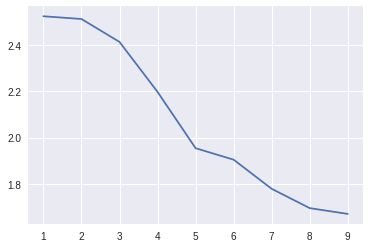

In [14]:
plt.plot(K, distortions)

Using the elbow method, we observe that using K = 5 would most probably yield the best results

#### Step 2.2. Applying K-Means Clustering with K = 5

In [55]:
kmeans = KMeans(5, random_state = 101)
kmeans.fit(shop_a_observations)

clusters = kmeans.cluster_centers_
labels = kmeans.labels_

### Step 3: Calculating the threshold distances

In [57]:
class DistancesToCluster():
    def __init__(self, which_cluster):
        self.which_cluster = which_cluster
        self.cluster = clusters[which_cluster]
        self.distances = []
        
    def calculate_distance_with(self, observation):
        difference = observation - self.cluster
        self.distances.append(np.linalg.norm(difference))
        
    def get_distances(self):
        return self.distances
        
distances = [DistancesToCluster(i) for i in range(5)] 
        
for i in range(len(labels)):
    which_cluster = labels[i]
        
    distances[which_cluster].calculate_distance_with(shop_a_observations[i])


In [60]:
thresholds = [np.percentile(distances[i].get_distances(), 90) for i in range(5)]

In [61]:
thresholds

[2.552497591788219,
 4.485826169415541,
 0.0,
 2.569259165461549,
 12.003030222024798]

#### *Whoops, that's a bit strange. How is it possible that there's a zero threshold? There seems to be a cluster formed with just one observation belonging to that particular cluster. Lets proceed to confirm that*

In [64]:
for i in range(len(labels)):
    which_cluster = labels[i]
    
    if which_cluster == 2:
        print("Found one at index {}".format(i))
        
    distances[which_cluster].calculate_distance_with(shop_a_observations[i])

Found one at index 6395


#### *My assumption has proven to be correct, There's a high probability that this is an outlier. Lets remove that observation from our model and re-do our algorithm*

In [74]:
shop_a_observations = np.delete(shop_a_observations, 6395, 0)

### Re-doing Step 2,3

#### Step 2.1 Elbow Method

In [75]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1,10)

distortions = []
for k in K:
    print("Doing K-Means Clustering with k = {}".format(k))
    kmeans = KMeans(k)
    kmeans.fit(shop_a_observations)
    distortions.append(sum(np.min(cdist(shop_a_observations, kmeans.cluster_centers_, 'euclidean'), axis=1)) / len(shop_a_observations))


Doing K-Means Clustering with k = 1
Doing K-Means Clustering with k = 2
Doing K-Means Clustering with k = 3
Doing K-Means Clustering with k = 4
Doing K-Means Clustering with k = 5
Doing K-Means Clustering with k = 6
Doing K-Means Clustering with k = 7
Doing K-Means Clustering with k = 8
Doing K-Means Clustering with k = 9


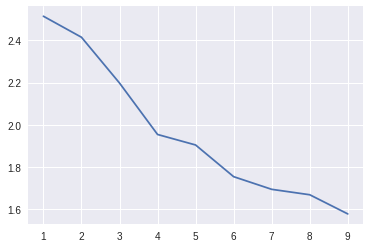

In [76]:
plt.plot(K, distortions)

Since we removed the outliers, the optimal K value changes to 4. Lets use that for our future observations

#### Step 2.2. Applying K Means Clustering with K = 4

In [78]:
kmeans = KMeans(4, random_state = 101)
kmeans.fit(shop_a_observations)

clusters = kmeans.cluster_centers_
labels = kmeans.labels_

In [79]:
class DistancesToCluster():
    def __init__(self, which_cluster):
        self.which_cluster = which_cluster
        self.cluster = clusters[which_cluster]
        self.distances = []
        
    def calculate_distance_with(self, observation):
        difference = observation - self.cluster
        self.distances.append(np.linalg.norm(difference))
        
    def get_distances(self):
        return self.distances
        
distances = [DistancesToCluster(i) for i in range(4)] 
        
for i in range(len(labels)):
    which_cluster = labels[i]
        
    distances[which_cluster].calculate_distance_with(shop_a_observations[i])


In [82]:
thresholds = [np.percentile(distances[i].get_distances(), 90) for i in range(4)]

In [83]:
thresholds

[4.490151121375407, 2.552169442629009, 12.003030222024789, 2.569126995451737]

### Step 4. Predict Closest Cluster

In [84]:
preds = kmeans.predict(potential_customers_compressed)

### Step 5 and 6: Calculate euclidean distance of unlabeled instances and classify based on the threshold

In [85]:
potential_customer_flag = []

for i in range(len(potential_customers_compressed)):
    which_cluster = preds[i]
    cluster = clusters[which_cluster]
    
    diff = potential_customers_compressed[i] - cluster
    dist = np.linalg.norm(diff)
    
    if dist > thresholds[which_cluster]:
        potential_customer_flag.append(0)
    else:
        potential_customer_flag.append(1)

In [86]:
potential_customers_data['potential_A_customer'] = potential_customer_flag

/home/saa2/pytorch_new/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
target_customers_ids = potential_customers_data[potential_customers_data['potential_A_customer'] == 1]['user_id']

In [88]:
target_customers_ids.to_csv('../data/task_2.csv')